# Advance Model Exploration

#### Import all the required libraries

In [62]:
# Import libraries
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.corpus import stopwords
import nltk
import warnings
from sklearn.exceptions import ConvergenceWarning
# Suppress warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

#### Read the data into a pandas dataframe

In [15]:
# Read the CSV file into a DataFrame
df = pd.read_csv('../data/original_raw_data.csv')

In [16]:
df.sample(5)

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
18151,18556,3,0,0,3,2,"RT @Yankees: Congrats to Derek Jeter, who will..."
2974,3046,3,0,3,0,1,@Darth_Maxwell dude I was pissed but then look...
416,422,3,1,2,0,1,"""@xoxoclauudia: YASSSSSS, ORDERED CHINESE &#12..."
5763,5927,3,0,2,1,1,@corey_emanuel bet.... Pay back is a bitch
1573,1608,3,0,3,0,1,&#8220;@ToriJBerman: Shavonne was doing ballet...


In [17]:
# Removing the 'Unnamed: 0' column
df = df.drop('Unnamed: 0', axis=1)

In [18]:
df.sample(5)

,count,hate_speech,offensive_language,neither,class,tweet
7280,3,2,1,0,0,@white_thunduh my bitch dont want your ugly as...
8090,6,2,4,0,1,Bitches so stupid!!! Yal can't know how I'm bo...
10176,3,2,1,0,0,I didn't forsake all other bitches for my wife...
756,3,0,1,2,2,#RadioFreeNorthwest 218\nCovington reads respo...
3763,3,0,3,0,1,@KatieFraaancis bitch nigga


### Understanding the Features

    1 - count (numeric - representative of the total number of people who rated this entry)
    2 - hate_speech (numeric - from the total count above)
    3 - offensive_language (numeric - from the total count above)
    4 - neither (numeric - from the total count above)
    5 - class (numeric 0 - offensive , 1 - hate speech or 2 - neither)
    6 - tweet - (text) 

In [19]:
# Initialize lemmatizer, stemmer and TweetTokenizer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
tweet_tokenizer = TweetTokenizer()

In [20]:
# Define stopwords
stop_words = set(stopwords.words('english'))

# Remove 'rt' as it refer to a re-tweet in the tweeet and is non important for our model
stop_words.update(['RT', 'I'])

>The preprocess_text function below **tokenizes** the input text, **lemmatizes and stems the tokens**, **removes stopwords** and **non-alphabetic** tokens. The function then **joins** the processed tokens back into a single string and returns it.

In [21]:
def preprocess_text(text):
    # Tokenize the text
    word_tokens = tweet_tokenizer.tokenize(text)

    # Lemmatize the tokens, stem the tokens, remove stopwords and non-alphabetic tokens
    processed_tokens = [stemmer.stem(lemmatizer.lemmatize(w)) for w in word_tokens if w not in stop_words and w.isalpha()]

    # Join the tokens back into a single string and return it
    return ' '.join(processed_tokens)

In [22]:
# Apply the preprocessing function to the 'tweet' column
df['processed_tweet'] = df['tweet'].apply(preprocess_text)

In [23]:
df

,count,hate_speech,offensive_language,neither,class,tweet,processed_tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,as woman complain clean hous man alway take trash
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,boy dat cold tyga dwn bad cuffin dat hoe place
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,dawg you ever fuck bitch start cri you confus ...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,look like tranni
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,the shit hear might true might faker bitch tol...
...,...,...,...,...,...,...,...
24778,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,muthaf lie right hi tl trash now mine bibl scr...
24779,3,0,1,2,2,"you've gone and broke the wrong heart baby, an...",gone broke wrong heart babi drove redneck crazi
24780,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...,young buck wanna eat dat nigguh like aint fuck...
24781,6,0,6,0,1,youu got wild bitches tellin you lies,youu got wild bitch tellin lie


### train_test_split 

In [29]:
# Prepare the text data
X_processed = df['processed_tweet']
y = df['class']

X_train_processed, X_test_processed, y_train_processed, y_test_processed = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Advance Model 1

## Logistic Regression

### GridSearchCV - Bag Of Words, Tf-Idf and Hashing 

In [50]:
# Create pipeline with vectorizers
vectorizers = [
    ('count_vectorizer', CountVectorizer()),
    ('tfidf_vectorizer', TfidfVectorizer()),
    ('hashing_vectorizer', HashingVectorizer())
]

# Only use Logistic Regression
classifiers = [
    ('logistic_regression', LogisticRegression(random_state=42))
]

lr_model_results = {}

for vectorizer_name, vectorizer in vectorizers:
    for classifier_name, classifier in classifiers:
        pipe = Pipeline([
            (vectorizer_name, vectorizer),
            (classifier_name, classifier)
        ])
        
        if vectorizer_name != 'hashing_vectorizer':
            param_grid = {
                'logistic_regression__C': [0.1, 1, 10],
                f'{vectorizer_name}__ngram_range': [(1, 1), (1, 2)],
                f'{vectorizer_name}__min_df': [1, 2, 5],
                f'{vectorizer_name}__stop_words': [None, 'english'],
                f'{vectorizer_name}__max_features': [None, 500, 1000]
            }
        else: # no params for HashingVectorizer
            param_grid = {
                'logistic_regression__C': [0.1, 1, 10]
            }

        model_key = f'{classifier_name.replace("_", " ").title()} {vectorizer_name.replace("_", " ").title()}'
        lr_model_results[model_key] = {'best_params': None, 'best_score': 0, 'fit_time': 0}

        grid = GridSearchCV(pipe, param_grid, cv=5, verbose=1)
        start_time = time.time()
        grid.fit(X_train_processed, y_train_processed)
        elapsed_time = (time.time() - start_time) / 60

        if grid.best_score_ > lr_model_results[model_key]['best_score']:
            lr_model_results[model_key]['best_params'] = grid.best_params_
            lr_model_results[model_key]['best_score'] = grid.best_score_
            lr_model_results[model_key]['fit_time'] = elapsed_time

lr_results_df = pd.DataFrame(lr_model_results).T

lr_results_df

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits


,best_params,best_score,fit_time
Logistic Regression Count Vectorizer,"{'count_vectorizer__max_features': None, 'count_vectorizer__min_df': 2, 'count_vectorizer__ngram_range': (1, 2), 'count_vectorizer__stop_words': None, 'logistic_regression__C': 0.1}",0.904267,292.783455
Logistic Regression Tfidf Vectorizer,"{'logistic_regression__C': 10, 'tfidf_vectorizer__max_features': None, 'tfidf_vectorizer__min_df': 2, 'tfidf_vectorizer__ngram_range': (1, 2), 'tfidf_vectorizer__stop_words': None}",0.898366,288.380576
Logistic Regression Hashing Vectorizer,{'logistic_regression__C': 1},0.905175,257.734362


In [51]:
lr_results_df

,best_params,best_score,fit_time
Logistic Regression Count Vectorizer,"{'count_vectorizer__max_features': None, 'count_vectorizer__min_df': 2, 'count_vectorizer__ngram_range': (1, 2), 'count_vectorizer__stop_words': None, 'logistic_regression__C': 0.1}",0.904267,292.783455
Logistic Regression Tfidf Vectorizer,"{'logistic_regression__C': 10, 'tfidf_vectorizer__max_features': None, 'tfidf_vectorizer__min_df': 2, 'tfidf_vectorizer__ngram_range': (1, 2), 'tfidf_vectorizer__stop_words': None}",0.898366,288.380576
Logistic Regression Hashing Vectorizer,{'logistic_regression__C': 1},0.905175,257.734362


# Advance Model 2

## Decision Tree

### GridSearchCV - Bag Of Words, Tf-Idf, Hashing and Binary vectorazation

In [52]:
# Create pipeline with vectorizers and classifiers
vectorizers = [
    ('count_vectorizer', CountVectorizer()),
    ('tfidf_vectorizer', TfidfVectorizer()),
    ('hashing_vectorizer', HashingVectorizer(norm=None)),
    ('binary_vectorizer', CountVectorizer(binary=True))
]

classifiers = [
    ('decision_tree', DecisionTreeClassifier(random_state=42))
]

dt_model_results = {}

for vectorizer_name, vectorizer in vectorizers:
    for classifier_name, classifier in classifiers:
        pipe = Pipeline([
            (vectorizer_name, vectorizer),
            (classifier_name, classifier)
        ])

        if classifier_name == 'decision_tree':
            param_grid = {
                'decision_tree__max_depth': [5, 10, 15],
                f'{vectorizer_name}__ngram_range': [(1, 1), (1, 2)],
                f'{vectorizer_name}__stop_words': [None, 'english']
            }
            if vectorizer_name != 'hashing_vectorizer':
                param_grid[f'{vectorizer_name}__min_df'] = [1, 2, 5]
                param_grid[f'{vectorizer_name}__max_features'] = [None, 500, 1000]

        
        model_key = f'{classifier_name.replace("_", " ").title()} {vectorizer_name.replace("_", " ").title()}'
        dt_model_results[model_key] = {'best_params': None, 'best_score': 0, 'fit_time': 0}

        grid = GridSearchCV(pipe, param_grid, cv=5, verbose=1)
        start_time = time.time()
        grid.fit(X_train_processed, y_train_processed)
        elapsed_time = (time.time() - start_time) / 60
        
        if grid.best_score_ > dt_model_results[model_key]['best_score']:
            dt_model_results[model_key]['best_params'] = grid.best_params_
            dt_model_results[model_key]['best_score'] = grid.best_score_
            dt_model_results[model_key]['fit_time'] = elapsed_time

dt_results_df = pd.DataFrame(dt_model_results).T

dt_results_df

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits


,best_params,best_score,fit_time
Decision Tree Count Vectorizer,"{'count_vectorizer__max_features': None, 'count_vectorizer__min_df': 1, 'count_vectorizer__ngram_range': (1, 2), 'count_vectorizer__stop_words': None, 'decision_tree__max_depth': 15}",0.890346,124.378305
Decision Tree Tfidf Vectorizer,"{'decision_tree__max_depth': 15, 'tfidf_vectorizer__max_features': None, 'tfidf_vectorizer__min_df': 2, 'tfidf_vectorizer__ngram_range': (1, 2), 'tfidf_vectorizer__stop_words': None}",0.889892,145.672121
Decision Tree Hashing Vectorizer,"{'decision_tree__max_depth': 15, 'hashing_vectorizer__ngram_range': (1, 2), 'hashing_vectorizer__stop_words': None}",0.89085,88.78997
Decision Tree Binary Vectorizer,"{'binary_vectorizer__max_features': None, 'binary_vectorizer__min_df': 1, 'binary_vectorizer__ngram_range': (1, 2), 'binary_vectorizer__stop_words': None, 'decision_tree__max_depth': 15}",0.891254,123.700142


In [53]:
dt_results_df

,best_params,best_score,fit_time
Decision Tree Count Vectorizer,"{'count_vectorizer__max_features': None, 'count_vectorizer__min_df': 1, 'count_vectorizer__ngram_range': (1, 2), 'count_vectorizer__stop_words': None, 'decision_tree__max_depth': 15}",0.890346,124.378305
Decision Tree Tfidf Vectorizer,"{'decision_tree__max_depth': 15, 'tfidf_vectorizer__max_features': None, 'tfidf_vectorizer__min_df': 2, 'tfidf_vectorizer__ngram_range': (1, 2), 'tfidf_vectorizer__stop_words': None}",0.889892,145.672121
Decision Tree Hashing Vectorizer,"{'decision_tree__max_depth': 15, 'hashing_vectorizer__ngram_range': (1, 2), 'hashing_vectorizer__stop_words': None}",0.89085,88.78997
Decision Tree Binary Vectorizer,"{'binary_vectorizer__max_features': None, 'binary_vectorizer__min_df': 1, 'binary_vectorizer__ngram_range': (1, 2), 'binary_vectorizer__stop_words': None, 'decision_tree__max_depth': 15}",0.891254,123.700142


# Advance Model 3

## Random Forest

### GridSearchCV - Bag Of Words, Tf-Idf, Hashing and Binary vectorazation

In [54]:
# Create pipeline with vectorizers and classifiers
vectorizers = [
    ('count_vectorizer', CountVectorizer()),
    ('tfidf_vectorizer', TfidfVectorizer()),
    ('hashing_vectorizer', HashingVectorizer(norm=None)),
    ('binary_vectorizer', CountVectorizer(binary=True))
]

classifiers = [
    ('random_forest', RandomForestClassifier(n_estimators=100, random_state=42))
]

rf_model_results = {}

for vectorizer_name, vectorizer in vectorizers:
    for classifier_name, classifier in classifiers:
        pipe = Pipeline([
            (vectorizer_name, vectorizer),
            (classifier_name, classifier)
        ])

        param_grid = {
            'random_forest__n_estimators': [100, 200, 300],
            'random_forest__max_depth': [5, 10, 15],
            f'{vectorizer_name}__ngram_range': [(1, 1), (1, 2)],
            f'{vectorizer_name}__stop_words': [None, 'english']
        }
        
        # Condition to add parameters that aren't compatible with HashingVectorizer
        if vectorizer_name != 'hashing_vectorizer':
            param_grid[f'{vectorizer_name}__min_df'] = [1, 2, 5]
            param_grid[f'{vectorizer_name}__max_features'] = [None, 500, 1000]


        model_key = f'{classifier_name.replace("_", " ").title()} {vectorizer_name.replace("_", " ").title()}'
        rf_model_results[model_key] = {'best_params': None, 'best_score': 0, 'fit_time': 0}

        grid = GridSearchCV(pipe, param_grid, cv=5, verbose=1)
        start_time = time.time()
        grid.fit(X_train_processed, y_train_processed)
        elapsed_time = (time.time() - start_time) / 60
        
        if grid.best_score_ > rf_model_results[model_key]['best_score']:
            rf_model_results[model_key]['best_params'] = grid.best_params_
            rf_model_results[model_key]['best_score'] = grid.best_score_
            rf_model_results[model_key]['fit_time'] = elapsed_time

rf_results_df = pd.DataFrame(rf_model_results).T

rf_results_df

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


,best_params,best_score,fit_time
Random Forest Count Vectorizer,"{'count_vectorizer__max_features': 500, 'count_vectorizer__min_df': 5, 'count_vectorizer__ngram_range': (1, 2), 'count_vectorizer__stop_words': None, 'random_forest__max_depth': 15, 'random_forest__n_estimators': 300}",0.849188,1241.237928
Random Forest Tfidf Vectorizer,"{'random_forest__max_depth': 15, 'random_forest__n_estimators': 300, 'tfidf_vectorizer__max_features': 500, 'tfidf_vectorizer__min_df': 5, 'tfidf_vectorizer__ngram_range': (1, 2), 'tfidf_vectorizer__stop_words': None}",0.84596,1470.047399
Random Forest Hashing Vectorizer,"{'hashing_vectorizer__ngram_range': (1, 1), 'hashing_vectorizer__stop_words': None, 'random_forest__max_depth': 5, 'random_forest__n_estimators': 100}",0.774639,793.548688
Random Forest Binary Vectorizer,"{'binary_vectorizer__max_features': 500, 'binary_vectorizer__min_df': 2, 'binary_vectorizer__ngram_range': (1, 2), 'binary_vectorizer__stop_words': None, 'random_forest__max_depth': 15, 'random_forest__n_estimators': 300}",0.849087,1249.893998


In [55]:
rf_results_df

,best_params,best_score,fit_time
Random Forest Count Vectorizer,"{'count_vectorizer__max_features': 500, 'count_vectorizer__min_df': 5, 'count_vectorizer__ngram_range': (1, 2), 'count_vectorizer__stop_words': None, 'random_forest__max_depth': 15, 'random_forest__n_estimators': 300}",0.849188,1241.237928
Random Forest Tfidf Vectorizer,"{'random_forest__max_depth': 15, 'random_forest__n_estimators': 300, 'tfidf_vectorizer__max_features': 500, 'tfidf_vectorizer__min_df': 5, 'tfidf_vectorizer__ngram_range': (1, 2), 'tfidf_vectorizer__stop_words': None}",0.84596,1470.047399
Random Forest Hashing Vectorizer,"{'hashing_vectorizer__ngram_range': (1, 1), 'hashing_vectorizer__stop_words': None, 'random_forest__max_depth': 5, 'random_forest__n_estimators': 100}",0.774639,793.548688
Random Forest Binary Vectorizer,"{'binary_vectorizer__max_features': 500, 'binary_vectorizer__min_df': 2, 'binary_vectorizer__ngram_range': (1, 2), 'binary_vectorizer__stop_words': None, 'random_forest__max_depth': 15, 'random_forest__n_estimators': 300}",0.849087,1249.893998


# Advance Model 4

## Support Vector Machine

### RandomizedSearchCV - Bag Of Words, Tf-Idf

In [56]:
# Create pipeline with vectorizers and classifiers
vectorizers = [
    ('count_vectorizer', CountVectorizer()),
    ('tfidf_vectorizer', TfidfVectorizer())
]

classifiers = [
    ('svc', SVC(random_state=42))
]

svc_model_results = {}

for vectorizer_name, vectorizer in vectorizers:
    for classifier_name, classifier in classifiers:
        pipe = Pipeline([
            (vectorizer_name, vectorizer),
            (classifier_name, classifier)
        ])

        if classifier_name == 'svc':
            param_grid = {
                'svc__C': [0.1, 1, 10, 100],
                'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                'svc__degree': [2, 3, 4, 5],  # only used when kernel is 'poly'
                'svc__gamma': ['scale', 'auto'],
                f'{vectorizer_name}__ngram_range': [(1, 1), (1, 2)],
                f'{vectorizer_name}__min_df': [1, 2, 5],
                f'{vectorizer_name}__stop_words': [None, 'english'],
                f'{vectorizer_name}__max_features': [None, 500, 1000]
            }
        
        model_key = f'{classifier_name.replace("_", " ").title()} {vectorizer_name.replace("_", " ").title()}'
        svc_model_results[model_key] = {'best_params': None, 'best_score': 0, 'fit_time': 0}

        random_search = RandomizedSearchCV(pipe, param_grid, n_iter=100, cv=5, verbose=1, random_state=42)
        start_time = time.time()
        random_search.fit(X_train_processed, y_train_processed)
        elapsed_time = (time.time() - start_time) / 60
        
        if random_search.best_score_ > svc_model_results[model_key]['best_score']:
            svc_model_results[model_key]['best_params'] = random_search.best_params_
            svc_model_results[model_key]['best_score'] = random_search.best_score_
            svc_model_results[model_key]['fit_time'] = elapsed_time

svc_results_df = pd.DataFrame(svc_model_results).T

svc_results_df

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits


,best_params,best_score,fit_time
Svc Count Vectorizer,"{'svc__kernel': 'linear', 'svc__gamma': 'scale', 'svc__degree': 3, 'svc__C': 0.1, 'count_vectorizer__stop_words': None, 'count_vectorizer__ngram_range': (1, 1), 'count_vectorizer__min_df': 1, 'count_vectorizer__max_features': None}",0.905024,99.362124
Svc Tfidf Vectorizer,"{'tfidf_vectorizer__stop_words': None, 'tfidf_vectorizer__ngram_range': (1, 2), 'tfidf_vectorizer__min_df': 2, 'tfidf_vectorizer__max_features': None, 'svc__kernel': 'linear', 'svc__gamma': 'auto', 'svc__degree': 3, 'svc__C': 1}",0.906436,113.023715


In [67]:
svc_results_df

,best_params,best_score,fit_time
Svc Count Vectorizer,"{'svc__kernel': 'linear', 'svc__gamma': 'scale', 'svc__degree': 3, 'svc__C': 0.1, 'count_vectorizer__stop_words': None, 'count_vectorizer__ngram_range': (1, 1), 'count_vectorizer__min_df': 1, 'count_vectorizer__max_features': None}",0.905024,99.362124
Svc Tfidf Vectorizer,"{'tfidf_vectorizer__stop_words': None, 'tfidf_vectorizer__ngram_range': (1, 2), 'tfidf_vectorizer__min_df': 2, 'tfidf_vectorizer__max_features': None, 'svc__kernel': 'linear', 'svc__gamma': 'auto', 'svc__degree': 3, 'svc__C': 1}",0.906436,113.023715


# Advance Model 5

## K Neigbors

### RandomizedSearchCV

#### Bag Of Words, Tf-Idf, Hashing and Binary vectorazation

In [59]:
# Create pipeline with vectorizers and classifiers
vectorizers = [
    ('count_vectorizer', CountVectorizer()),
    ('tfidf_vectorizer', TfidfVectorizer())
]

classifiers = [
    ('k_neighbors', KNeighborsClassifier())
]

knn_model_results = {}

for vectorizer_name, vectorizer in vectorizers:
    for classifier_name, classifier in classifiers:
        pipe = Pipeline([
            (vectorizer_name, vectorizer),
            (classifier_name, classifier)
        ])

        if classifier_name == 'k_neighbors':
            param_grid = {
                'k_neighbors__n_neighbors': [3, 5, 7],
                f'{vectorizer_name}__ngram_range': [(1, 1), (1, 2)],
                f'{vectorizer_name}__min_df': [1, 2, 5],
                f'{vectorizer_name}__stop_words': [None, 'english'],
                f'{vectorizer_name}__max_features': [None, 500, 1000]
            }

        model_key = f'{classifier_name.replace("_", " ").title()} {vectorizer_name.replace("_", " ").title()}'
        knn_model_results[model_key] = {'best_params': None, 'best_score': 0, 'fit_time': 0}

        random_search = RandomizedSearchCV(pipe, param_grid, cv=5, verbose=1, n_iter=10, random_state=42)
        start_time = time.time()
        random_search.fit(X_train_processed, y_train_processed)
        elapsed_time = (time.time() - start_time) / 60  # convert to minutes
        
        if random_search.best_score_ > knn_model_results[model_key]['best_score']:
            knn_model_results[model_key]['best_params'] = random_search.best_params_
            knn_model_results[model_key]['best_score'] = random_search.best_score_
            knn_model_results[model_key]['fit_time'] = elapsed_time

knn_results_df = pd.DataFrame(knn_model_results).T

knn_results_df

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


,best_params,best_score,fit_time
K Neighbors Count Vectorizer,"{'k_neighbors__n_neighbors': 7, 'count_vectorizer__stop_words': 'english', 'count_vectorizer__ngram_range': (1, 2), 'count_vectorizer__min_df': 2, 'count_vectorizer__max_features': 1000}",0.877535,0.884922
K Neighbors Tfidf Vectorizer,"{'tfidf_vectorizer__stop_words': 'english', 'tfidf_vectorizer__ngram_range': (1, 2), 'tfidf_vectorizer__min_df': 5, 'tfidf_vectorizer__max_features': 500, 'k_neighbors__n_neighbors': 7}",0.773278,0.776486


In [66]:
knn_results_df

,best_params,best_score,fit_time
K Neighbors Count Vectorizer,"{'k_neighbors__n_neighbors': 7, 'count_vectorizer__stop_words': 'english', 'count_vectorizer__ngram_range': (1, 2), 'count_vectorizer__min_df': 2, 'count_vectorizer__max_features': 1000}",0.877535,0.884922
K Neighbors Tfidf Vectorizer,"{'tfidf_vectorizer__stop_words': 'english', 'tfidf_vectorizer__ngram_range': (1, 2), 'tfidf_vectorizer__min_df': 5, 'tfidf_vectorizer__max_features': 500, 'k_neighbors__n_neighbors': 7}",0.773278,0.776486


# Advance Model 6

## XGB

### RandomizedSearchCV

#### Bag Of Words, Tf-Idf, Hashing and Binary vectorazation

In [64]:
# Create pipeline with vectorizers and classifiers
vectorizers = [
    ('count_vectorizer', CountVectorizer()),
    ('tfidf_vectorizer', TfidfVectorizer())
]

classifiers = [
    ('xgb', XGBClassifier(random_state=42))
]

xgb_model_results = {}

for vectorizer_name, vectorizer in vectorizers:
    for classifier_name, classifier in classifiers:
        pipe = Pipeline([
            (vectorizer_name, vectorizer),
            (classifier_name, classifier)
        ])

        param_dist = {
            'xgb__n_estimators': [100, 200, 300],
            'xgb__learning_rate': [0.1, 0.01],
            'xgb__reg_alpha': [0, 0.001, 0.005, 0.01, 0.05],
            'xgb__reg_lambda': [0.1, 1.0, 5.0],
            'xgb__booster': ['gbtree', 'gblinear', 'dart'],
            f'{vectorizer_name}__ngram_range': [(1, 1), (1, 2)],
            f'{vectorizer_name}__min_df': [1, 2, 5],
            f'{vectorizer_name}__stop_words': [None, 'english'],
            f'{vectorizer_name}__max_features': [None, 500, 1000]
        }

        model_key = f'{classifier_name.replace("_", " ").title()} {vectorizer_name.replace("_", " ").title()}'
        xgb_model_results[model_key] = {'best_params': None, 'best_score': 0, 'fit_time': 0}

        random_search = RandomizedSearchCV(pipe, param_distributions=param_dist, n_iter=10, cv=5, verbose=1)
        start_time = time.time()
        random_search.fit(X_train_processed, y_train_processed)
        elapsed_time = (time.time() - start_time) / 60  # convert to minutes
        
        if random_search.best_score_ > xgb_model_results[model_key]['best_score']:
            xgb_model_results[model_key]['best_params'] = random_search.best_params_
            xgb_model_results[model_key]['best_score'] = random_search.best_score_
            xgb_model_results[model_key]['fit_time'] = elapsed_time

xgb_results_df = pd.DataFrame(xgb_model_results).T

xgb_results_df

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


,best_params,best_score,fit_time
Xgb Count Vectorizer,"{'xgb__reg_lambda': 1.0, 'xgb__reg_alpha': 0.005, 'xgb__n_estimators': 200, 'xgb__learning_rate': 0.1, 'xgb__booster': 'dart', 'count_vectorizer__stop_words': None, 'count_vectorizer__ngram_range': (1, 2), 'count_vectorizer__min_df': 5, 'count_vectorizer__max_features': 1000}",0.90341,12.849408
Xgb Tfidf Vectorizer,"{'xgb__reg_lambda': 0.1, 'xgb__reg_alpha': 0.01, 'xgb__n_estimators': 200, 'xgb__learning_rate': 0.1, 'xgb__booster': 'dart', 'tfidf_vectorizer__stop_words': 'english', 'tfidf_vectorizer__ngram_range': (1, 2), 'tfidf_vectorizer__min_df': 2, 'tfidf_vectorizer__max_features': 500}",0.898315,9.099797


In [65]:
xgb_results_df

,best_params,best_score,fit_time
Xgb Count Vectorizer,"{'xgb__reg_lambda': 1.0, 'xgb__reg_alpha': 0.005, 'xgb__n_estimators': 200, 'xgb__learning_rate': 0.1, 'xgb__booster': 'dart', 'count_vectorizer__stop_words': None, 'count_vectorizer__ngram_range': (1, 2), 'count_vectorizer__min_df': 5, 'count_vectorizer__max_features': 1000}",0.90341,12.849408
Xgb Tfidf Vectorizer,"{'xgb__reg_lambda': 0.1, 'xgb__reg_alpha': 0.01, 'xgb__n_estimators': 200, 'xgb__learning_rate': 0.1, 'xgb__booster': 'dart', 'tfidf_vectorizer__stop_words': 'english', 'tfidf_vectorizer__ngram_range': (1, 2), 'tfidf_vectorizer__min_df': 2, 'tfidf_vectorizer__max_features': 500}",0.898315,9.099797


### Merge all results_df

In [68]:
# Merge the verious dataframes onto one results dataframe
combined_results_df = pd.concat([lr_results_df, dt_results_df, rf_results_df, svc_results_df, knn_results_df, xgb_results_df])

In [69]:
combined_results_df

,best_params,best_score,fit_time
Logistic Regression Count Vectorizer,"{'count_vectorizer__max_features': None, 'count_vectorizer__min_df': 2, 'count_vectorizer__ngram_range': (1, 2), 'count_vectorizer__stop_words': None, 'logistic_regression__C': 0.1}",0.904267,292.783455
Logistic Regression Tfidf Vectorizer,"{'logistic_regression__C': 10, 'tfidf_vectorizer__max_features': None, 'tfidf_vectorizer__min_df': 2, 'tfidf_vectorizer__ngram_range': (1, 2), 'tfidf_vectorizer__stop_words': None}",0.898366,288.380576
Logistic Regression Hashing Vectorizer,{'logistic_regression__C': 1},0.905175,257.734362
Decision Tree Count Vectorizer,"{'count_vectorizer__max_features': None, 'count_vectorizer__min_df': 1, 'count_vectorizer__ngram_range': (1, 2), 'count_vectorizer__stop_words': None, 'decision_tree__max_depth': 15}",0.890346,124.378305
Decision Tree Tfidf Vectorizer,"{'decision_tree__max_depth': 15, 'tfidf_vectorizer__max_features': None, 'tfidf_vectorizer__min_df': 2, 'tfidf_vectorizer__ngram_range': (1, 2), 'tfidf_vectorizer__stop_words': None}",0.889892,145.672121
Decision Tree Hashing Vectorizer,"{'decision_tree__max_depth': 15, 'hashing_vectorizer__ngram_range': (1, 2), 'hashing_vectorizer__stop_words': None}",0.89085,88.78997
Decision Tree Binary Vectorizer,"{'binary_vectorizer__max_features': None, 'binary_vectorizer__min_df': 1, 'binary_vectorizer__ngram_range': (1, 2), 'binary_vectorizer__stop_words': None, 'decision_tree__max_depth': 15}",0.891254,123.700142
Random Forest Count Vectorizer,"{'count_vectorizer__max_features': 500, 'count_vectorizer__min_df': 5, 'count_vectorizer__ngram_range': (1, 2), 'count_vectorizer__stop_words': None, 'random_forest__max_depth': 15, 'random_forest__n_estimators': 300}",0.849188,1241.237928
Random Forest Tfidf Vectorizer,"{'random_forest__max_depth': 15, 'random_forest__n_estimators': 300, 'tfidf_vectorizer__max_features': 500, 'tfidf_vectorizer__min_df': 5, 'tfidf_vectorizer__ngram_range': (1, 2), 'tfidf_vectorizer__stop_words': None}",0.84596,1470.047399
Random Forest Hashing Vectorizer,"{'hashing_vectorizer__ngram_range': (1, 1), 'hashing_vectorizer__stop_words': None, 'random_forest__max_depth': 5, 'random_forest__n_estimators': 100}",0.774639,793.548688


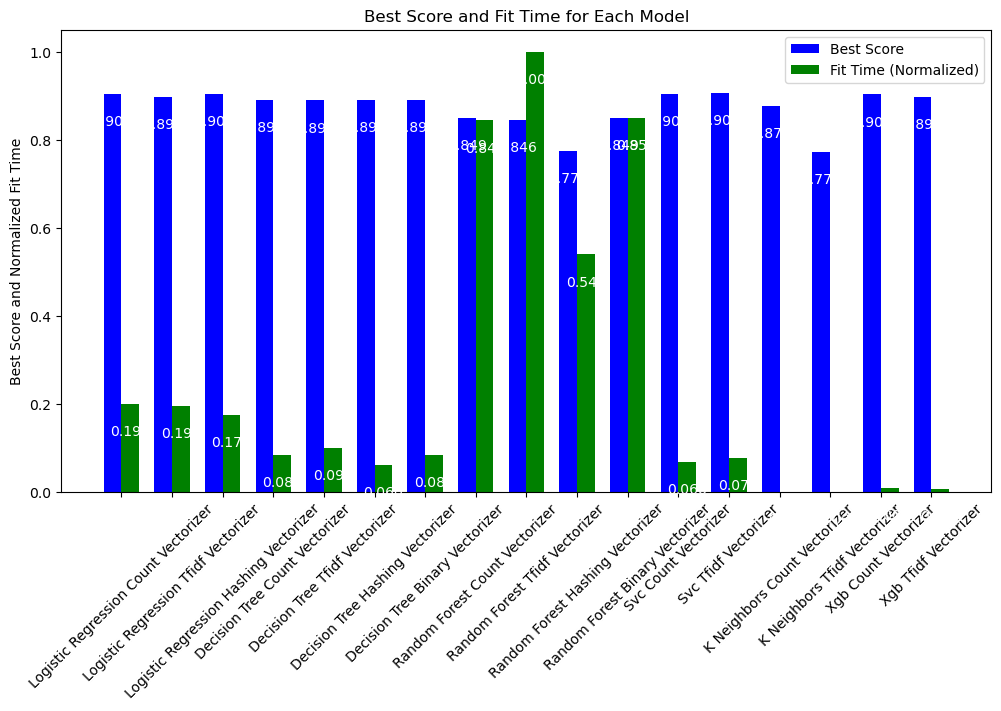

In [72]:
# Function to add labels at the top of the bars
def autolabel(rects, ax):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.3f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, -25),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', color='white')
        
# Set the width of the bars
bar_width = 0.35

# Set the x-axis values
x = np.arange(len(combined_results_df.index))

# Create the bar plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the best_score bars
best_score_bars = ax1.bar(x - bar_width/2, combined_results_df['best_score'], width=bar_width, label='Best Score', color='blue')

# Plot the fit_time bars
fit_time_bars = ax1.bar(x + bar_width/2, combined_results_df['fit_time'] / combined_results_df['fit_time'].max(), width=bar_width, label='Fit Time (Normalized)', color='green')

# Customize the plot
ax1.set_xticks(x)
ax1.set_xticklabels(combined_results_df.index, rotation=45)
ax1.set_ylabel('Best Score and Normalized Fit Time')
ax1.set_title('Best Score and Fit Time for Each Model')
ax1.legend()

# Add labels at the top of the bars
autolabel(best_score_bars, ax1)
autolabel(fit_time_bars, ax1)

# Save the plot to a file
plt.savefig('../plots/Best Score and Fit Time for Each Model.png', bbox_inches='tight')

# Display the plot
plt.show()

# To Do


### Select best model

### Enhanced parameter search and vectorizers...

### Plot model performance